In [13]:
import torch

# 加载保存的张量
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Forecasting_rain/outputs.pth')

# 将小于0.1的值设置为0
prediction[prediction < 0.001] = 0

# 如果需要，保存修改后的张量
torch.save(prediction, '/root/autodl-tmp/competition/cpt/FURENet_Forecasting_rain/processed_outputs.pth')

In [14]:
# 检查是否存在负值
has_negative_values = torch.any(torch.lt(prediction, 0))

# 输出结果
print(has_negative_values.item()) 

False


In [1]:
import torch

# 加载保存的张量
ground_truth = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Forecasting_rain/labels.pth')
prediction = torch.load('/root/autodl-tmp/competition/cpt/FURENet_Forecasting_rain/outputs.pth')


In [2]:
print(ground_truth.shape)
print(prediction.shape)

torch.Size([100, 10, 256, 256])
torch.Size([100, 10, 256, 256])


In [3]:
prediction[0][0].shape

torch.Size([256, 256])

In [4]:
import numpy as np

# 将torch.Tensor转换为numpy数组
prediction_numpy = prediction[0][0].cpu().numpy()

# 保存numpy数组到CSV文件
# np.savetxt('prediction.csv', prediction_numpy, delimiter=',')


In [5]:
def denormalize(tensor, norm_param):
    mmin, mmax = norm_param
    denormalized_tensor = tensor * (mmax - mmin) + mmin
    return denormalized_tensor

# 反归一化
norm_param_dbz = [0, 500]  # 以降雨量为例
ground_truth_denorm = denormalize(ground_truth, norm_param_dbz)
prediction_denorm = denormalize(prediction, norm_param_dbz)

# 计算评估指标
error = torch.abs(ground_truth_denorm - prediction_denorm).mean()


In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# 将张量转换为 NumPy 数组
ground_truth_np = ground_truth_denorm.cpu().numpy()
prediction_np = prediction_denorm.cpu().numpy()

# 计算每个样本的 MAE
mae_per_sample = np.mean(np.abs(ground_truth_np - prediction_np), axis=(1,2,3))

# 计算总的 MAE
total_mae = np.mean(mae_per_sample)

print(f'Total MAE: {total_mae}')


Total MAE: 2.491621971130371


In [7]:
import torch

def mape(ground_truth, prediction, eps=1e-8):
    # 避免除以零的错误
    denominator = ground_truth + eps
    
    # 计算每个元素的绝对百分比误差
    abs_percent_error = torch.abs((ground_truth - prediction) / denominator)
    
    # 计算并返回平均绝对百分比误差
    return torch.mean(abs_percent_error) * 100

# 计算 MAPE
mape_value = mape(ground_truth, prediction)
print(f'MAPE: {mape_value.item()}%')


MAPE: 31243828.0%


In [8]:
## 计算CSI
import torch

# 设定阈值
threshold = 1

# 将数据转换为二进制（强对流为1，非强对流为0）
ground_truth_bin = (ground_truth_np >= threshold).astype(float)
prediction_bin = (prediction_np >= threshold).astype(float)

# 计算 Hits, Misses, 和 False Alarms
hits = np.sum(ground_truth_bin * prediction_bin)
misses = np.sum(ground_truth_bin * (1 - prediction_bin))
false_alarms = np.sum((1 - ground_truth_bin) * prediction_bin)

# 计算 CSI
csi = hits / (hits + misses + false_alarms)
# csi = csi.item()  # 转换为Python标量

print(f'CSI: {csi:.2f}')


CSI: 0.05


In [24]:
# 计算召回率
recall = hits / (hits + misses)

print(f'Recall: {recall:.2f}')


Recall: 0.01


In [25]:
# 计算精确度
precision = hits / (hits + false_alarms)

print(f'Precision: {precision:.2f}')


Precision: 0.38


In [88]:
# 用前面计算的精确度和召回率来计算F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1 Score: {f1_score:.2f}')


F1 Score: 0.22


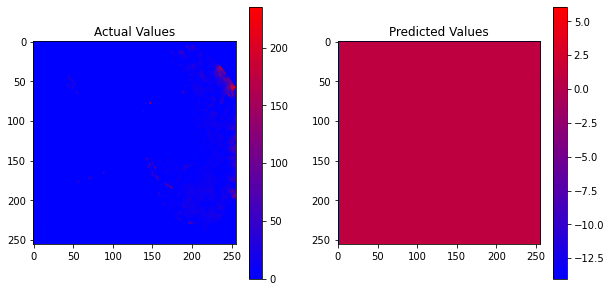

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np  # 导入numpy以便创建示例数据

# 创建从蓝色过渡到红色的颜色映射
colors = [(0, 0, 1), (1, 0, 0)]  # 蓝色到红色
new_map = mcolors.LinearSegmentedColormap.from_list('blue_to_red', colors, N=256)

# 创建示例数据
# ground_truth_np = np.random.random((10, 10, 256, 256))  # 创建示例ground_truth_np数据
# prediction_np = np.random.random((10, 10, 256, 256))  # 创建示例prediction_np数据

# 选择一个样本
sample_idx = 2  # 选择第一个样本，你可以更改此索引以查看其他样本
ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 选择一个通道/时间步
channel_idx = 1  # 选择第一个通道/时间步，你可以更改此索引以查看其他通道/时间步
ground_truth_channel = ground_truth_sample[channel_idx]
prediction_channel = prediction_sample[channel_idx]

# 绘制实际值和预测值
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_channel, cmap=new_map, origin='upper')
plt.title('Actual Values')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(prediction_channel, cmap=new_map, origin='upper')
plt.title('Predicted Values')
plt.colorbar()

plt.show()


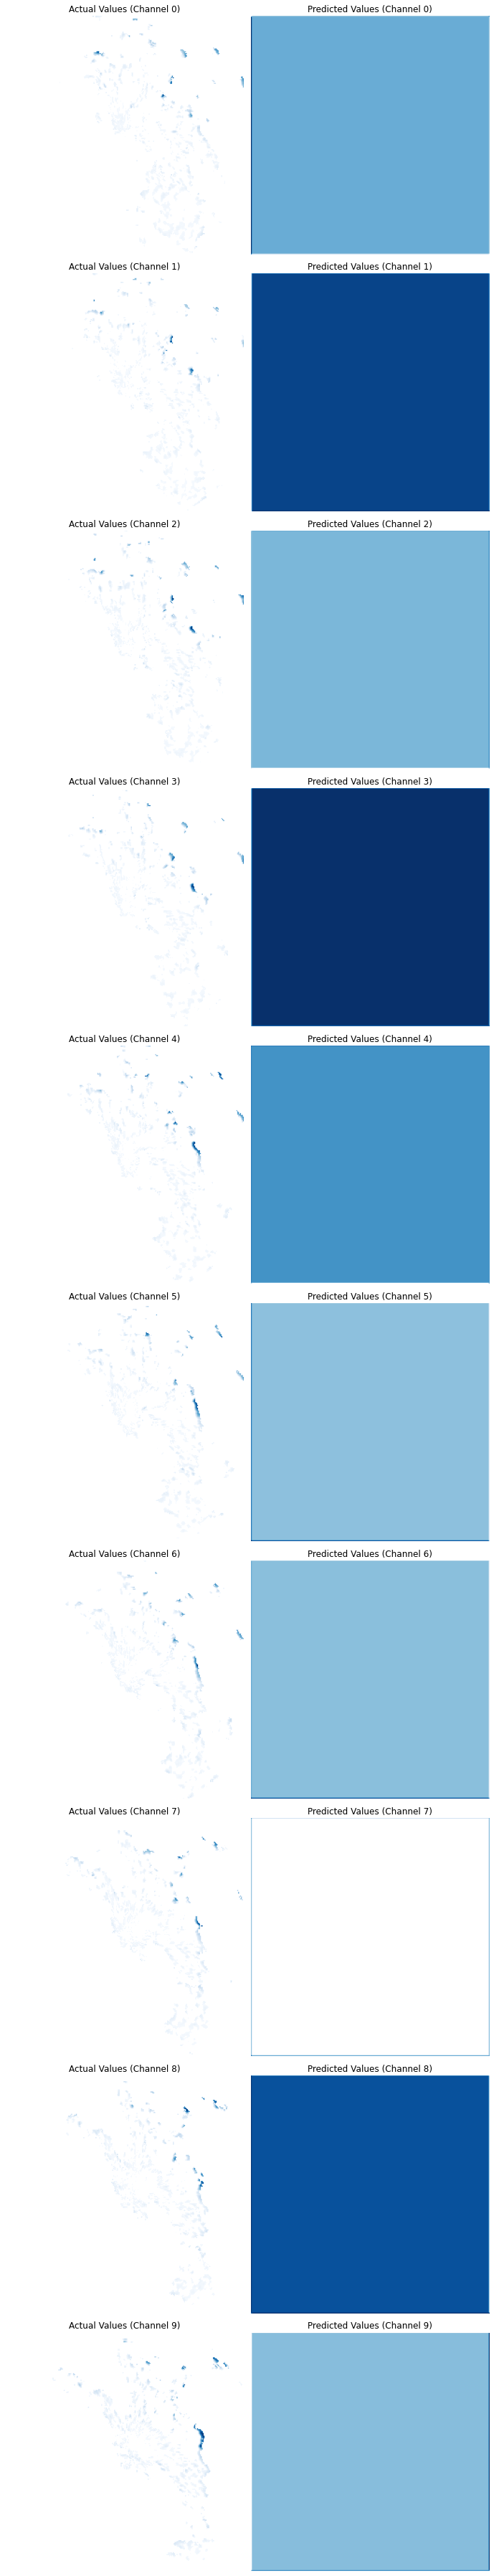

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np

# 创建自定义颜色映射
colors = [(1, 1, 1)] + [(cm.Blues(i)) for i in range(1, 256)]
new_map = mcolors.LinearSegmentedColormap.from_list('new_map', colors, N=256)
# colors = [(0, 0, 1), (1, 0, 0)]  # 蓝色到红色
# new_map = mcolors.LinearSegmentedColormap.from_list('blue_to_red', colors, N=256)

# 选择一个样本
sample_idx = 58  # 选择第一个样本，你可以更改此索引以查看其他样本

ground_truth_sample = ground_truth_np[sample_idx]
prediction_sample = prediction_np[sample_idx]

# 获取通道/时间步的数量
num_channels = ground_truth_sample.shape[0]

# 创建一个大图，其中每个通道/时间步都有自己的子图
fig, axs = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for channel_idx in range(num_channels):
    ground_truth_channel = ground_truth_sample[channel_idx]
    prediction_channel = prediction_sample[channel_idx]
    
    # 左列显示真实值
    axs[channel_idx, 0].imshow(ground_truth_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 0].set_title(f'Actual Values (Channel {channel_idx})')
    axs[channel_idx, 0].axis('off')
    
    # 右列显示预测值
    axs[channel_idx, 1].imshow(prediction_channel, cmap=new_map, origin='upper')
    axs[channel_idx, 1].set_title(f'Predicted Values (Channel {channel_idx})')
    axs[channel_idx, 1].axis('off')

# 调整子图之间的间距
plt.tight_layout()
plt.show()
